In [140]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import operator
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [141]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'PAD', 1: 'SOS', 2:'EOS', 3:'UNK'}#Dict
        self.n_words = 4  # Count SOS and EOS +(batch: pad and unk)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [142]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4491
eng 2927
['je conduis .', 'i m driving .']


In [143]:
pairs[419]

['nous sommes seules .', 'we re alone .']

### The above is the data preparation stage(for single batch). No code shall be changed. 

### Batch size modification
----
1. pairs -> refers to Fr-En letter pairs
2. index_pairs -> refers to Fr-En index pairs

In [144]:
class NMTDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang):#Needs the index pairs
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.input_seqs = [pairs[i][0] for i in range(len(self.pairs))]
        self.output_seqs = [pairs[i][1] for i in range(len(self.pairs))]

    def __len__(self):
        return len(self.pairs)#Returning number of pairs
    
    def __getitem__(self, index):
        input_seq = self.input_seqs[index]
        output_seq = self.output_seqs[index]
        return [input_seq, len(input_seq), output_seq, len(output_seq)]
    
def vocab_collate_func(batch):
    #Reference: lab8_3_mri
    def _pad_sequences(seqs):
        lens = [len(seq) for seq in seqs]
        padded_seqs = torch.zeros(len(seqs), max(lens)).long()
        for i, seq in enumerate(seqs):
            end = lens[i]
            padded_seqs[i, :end] = torch.LongTensor(seq[:end])
        return padded_seqs, lens
    
    batch_input_seqs = [datum[0] for datum in batch]
    batch_output_seqs = [datum[2] for datum in batch]
    #batch_input_length = [datum[1] for datum in batch]
    #batch_output_length = [datum[3] for datum in batch]

    sorted_pairs = sorted(zip(batch_input_seqs, batch_output_seqs), key=lambda x: len(x[0]), reverse = True)
    in_seq_sorted, out_seq_sorted = zip(*sorted_pairs)
    
    padded_input,input_lens = _pad_sequences(in_seq_sorted)
    padded_output,output_lens = _pad_sequences(out_seq_sorted)
    
    return [torch.from_numpy(np.array(padded_input)),
            torch.LongTensor(input_lens),
            torch.from_numpy(np.array(padded_output)),
            torch.LongTensor(output_lens)]

In [145]:
index_pairs = [[indexesFromSentence(input_lang, pairs[i][0]),
                indexesFromSentence(output_lang, pairs[i][1])] for i in range(len(pairs))]
#index_pairs = indexesFromPair(pair)

'''
NMTDataset needs index pairs, need to call indexesFromPairs functions beforehand
The dataLoader is sorted according to length of the input_length, and padded to
max length of input and output list repectively
TODO: output_list is not sorted, hence need to sort (maybe) in the rnn sequence.
'''
train_dataset = NMTDataset(index_pairs, input_lang, output_lang)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                          batch_size = BATCH_SIZE,
                                          collate_fn = vocab_collate_func,
                                          shuffle = True)
#Input_batch in size Batch x maxLen


In [323]:
# #Test for batch sizes
for i, (input_list, input_length, output_list, output_length) in enumerate(train_loader):
    if i== 0:
        break

In [147]:
input_list.size()

torch.Size([3, 9])

In [16]:
input_length

tensor([8, 5, 5])

In [17]:
output_list.size()

torch.Size([3, 8])

In [18]:
output_length

tensor([8, 6, 6])

## 1. First test out with no batch size

### 1.1 Encoder with no batch

In [148]:
#Here for the constant definition
MAX_SENTENCE_LENGTH = 10
hidden_size = 256
max_length = 10
BATCH_SIZE = 3
TEST_BATCH_SIZE = 3


In [ ]:
#unbatched RNNEncoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1) # B x 1 x H
        #print('The embeddded size is {}'.format(embedded.size()))
        #When feeded in batch sizes, the size will be B x 1 x H, one token at a time
        output = embedded##Need changes if doing the batch size
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size, device = device)

In [ ]:
#For 1 batch size, prepare the test data
source_list = [pairs[i][0] for i in range(10)]
output_list = [pairs[i][1] for i in range(10)]

#Here they are strings:
input_tensor = source_list[0]
output_tensor = output_list[0]

#Transfer to tensor
input_tensor = tensorFromSentence(input_lang, input_tensor)
output_tensor = tensorFromSentence(output_lang, output_tensor)


In [ ]:
encoder = EncoderRNN(input_lang.n_words, hidden_size)
if device == torch.device('cuda'):
    encoder.cuda()
else:
    encoder.cpu()

In [ ]:
input_length = input_tensor.size(0)
output_length = output_tensor.size(0)

encoder_outputs = torch.zeros(MAX_SENTENCE_LENGTH, 
                              encoder.hidden_size, 
                              device = device)#10x256
encoder_hidden = encoder.initHidden()#1x1x256

#Encode the sentence one index at a time
for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0,0]

### 1.2 Encoder with batch

In [307]:
class BatchEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, n_layers=1, dropout=0.1):
        super(BatchEncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional = True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        '''
        input_seqs in size B x L sorted in decreasing order -> will transpose to fit in embedding dimension
        '''
        embedded = self.embedding(input_seqs.transpose(0,1))#input_seqs B x L -> transpose to L x B
        #Input length sorted by loader
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        #Outputs in shape L x B x 2H, hidden as the last state of the GRU
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        hidden = hidden[:self.n_layers, :, :] + hidden[self.n_layers:,:,:]#Sum bidrectional information
        
        #outputs L x B x H
        #hidden size (n_layers) x B x H

        #outputs: seq_len x Batch x H
        return outputs, hidden
    
    def initHidden(self):
        return torch.zeros(self.n_layers *2, self.batch_size, self.hidden_size,device = device)#hidden size 2lays *B*H

### Dimension test

In [266]:
batch_encoder = BatchEncoderRNN(input_lang.n_words, hidden_size, BATCH_SIZE, n_layers = 2, dropout = 0.1)
init_hidden = batch_encoder.initHidden()
encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, init_hidden)
#inithidden bidirectional, encoder_hidden, summing up both directions
init_hidden.size(), encoder_outputs.size(), encoder_hidden.size()

(torch.Size([4, 3, 256]), torch.Size([9, 3, 256]), torch.Size([4, 3, 256]))

### 1.3 Decoder with Attention
The decoder has already been batchified. Therefore 
if feeding 1 sentence at a time make sure unsqueeze the batch dimension

In [151]:
#Reference: lab8 3_mri, Luong model
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            #self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
    
    def forward(self, hidden, encoder_outputs):
        # Create variable to store attention energies
        # For each batch of encoder outputs Calculate energy for each encoder output
        beta = self.score(hidden, encoder_outputs)#Len x Batch
        #print('The size for beta is {}'.format(beta.size()))
        alpha = F.softmax(beta.transpose(0,1)).unsqueeze(1)#B x 1 x L
        #encoder_ouputs L x B x H originally -> transpose to B x L x H
        #alpha bmm encoder_outputs: B x 1 x L bmm B x L x H -> B x 1 x N
        context = alpha.bmm(encoder_outputs.transpose(0,1))#B X 1 X N        
        
        # Return context vectors and attnetion weights for visualization
        return context, alpha
    
    def score(self, hidden, encoder_outputs):
        
        if self.method == 'dot':
            ## TODO implement
            energy = torch.sum(hidden*encoder_outputs, 2)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_outputs)
            ## TODO implement 
            energy = torch.sum(hidden*energy,2)
            return energy
        
        elif self.method == 'concat':
            cat = torch.cat((hidden.repeat(encoder_outputs.size(0), 1,1),encoder_outputs),dim=2)
            energy = F.tanh(self.attn(cat))
            ## TODO implement 
            energy = torch.sum(self.v * energy, 2)
            return energy

In [152]:
#Reference Lab8 3-mri, Luong model
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=PAD_TOKEN)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x H

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        context, alpha = self.attn(rnn_output, encoder_outputs)

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)
        #Softmax to get the distribution
        output = F.softmax(output, dim=1)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, alpha

In [154]:
decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)
decoder_input = torch.tensor([[SOS_TOKEN]], device=device).repeat(TEST_BATCH_SIZE,1)
#decoder_hidden = encoder_hidden[:decoder_test.n_layers]
decoder_hidden = encoder_hidden
input_seq = decoder_input
last_hidden = decoder_hidden
attn_model = 'dot'
decoder_input.size(), decoder_hidden.size()
decoder_output, decoder_hidden, attn_weights = decoder_test(decoder_input, decoder_hidden, encoder_outputs)

#Test rounds
all_decoder_outputs = torch.zeros(output_length.max().item(), TEST_BATCH_SIZE, decoder_test.output_size)
for t in range(output_length.max().item()):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(decoder_input, decoder_hidden, encoder_outputs)
    all_decoder_outputs[t] = decoder_output
    decoder_input = output_list[:,t].unsqueeze(1)

# For single interations only, encoer_outputs already unsqueezed 

In [ ]:
#encoder_outputs = encoder_outputs.unsqueeze(0)
encoder_outputs.size()

In [ ]:
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words)
if device == torch.device('cuda'):
    attn_decoder.cuda()
else:
    attn_decoder.cpu()

In [ ]:
decoder_input = torch.tensor([[SOS_TOKEN]], device = device)
decoder_hidden = encoder_hidden#1x1x256

In [ ]:
for di in range(output_length):
    decoder_output, decoder_hidden, decoder_attntion = attn_decoder(decoder_input, 
                                                     decoder_hidden, encoder_outputs)
    decoder_input = output_tensor[di]

## Note: Encoder outputs remained unchanged -> can be used later for testing
# End of the decoder and encoder session
code shall not be changed. 
two sentence has already been encoded and now we
aim to generate best translation

## During the train, will not  have inference state
### During training, no beam needed -> only during the evaluations state -> reference: Chow's note
two methods: greedy and beam search

# First greedy search: training and evaluations

In [138]:
#Greedy search
#DOnt execute these
#Training process:
teacher_forcing_ratio = 0.6
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
    # Teacher forcing: Feed the target as the next input
    for di in range(output_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

else:
    # Without teacher forcing: use its own predictions as the next input
    for di in range(output_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        #topv is the score, topi is the index of the highest score
        topv, topi = decoder_output.topk(1)

        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_TOKEN:
            break

TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
#initialize the decoder_hidden here
decoder_input = torch.tensor([[SOS_TOKEN]], device = device)
decoder_hidden = encoder_hidden#1x1x256

In [139]:
#Evaluations:
decoded_words = []
decoder_attentions = torch.zeros(max_length, max_length)

for di in range(max_length):
    decoder_output, decoder_hidden, decoder_attention = attn_decoder(decoder_input, decoder_hidden, encoder_outputs)
    topv, topi = decoder_output.topk(1)#Take the best one
    #teacher forcing or not
    #decoder_input = topi.squeeze().detach()
    decoder_input = output_tensor[di]#For next round
    decoder_attentions[di] = decoder_attention[0,0]
    decoded_words.append(output_lang.index2word[topi.item()])#append the best token right now
    
    if decoder_input.item() == EOS_TOKEN:

        break;

NameError: name 'attn_decoder' is not defined

In [ ]:
decoder_attentions

# Batched  Beam Search: 

### Github beam search
reference: https://github.com/budzianowski/PyTorch-Beam-Search-Decoding/blob/master/decode_beam.py 

and prototype: https://github.com/shawnwun/NNDIAL. 

In [561]:
# RNN decoder with no attention used
class DecoderRNN(nn.Module):
    def __init__(self, emb_size, hidden_size, output_size, batch_size, n_layers=1, dropout_p = 0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.emb_size = emb_size
        self.batch_size = batch_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding(output_size, emb_size,padding_idx = PAD_TOKEN)
        self.gru = nn.GRU(emb_size, hidden_size, n_layers, dropout = dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        embedded = self.dropout(embedded)
        output = F.relu(embedded)
        output, hidden = self.gru(output, hidden)#output 1 x B x E, hidden n_layers x B x H
        out = self.out(output[0])
        out = self.softmax(out)
        #out size batch x output_lang vocab size
        #hidden n_layers x B x H
        return out, hidden
    
#     def initHidden(self):
#         return torch.zeros(self.n_layers, self.batch_size, self.hidden_size, device = device)
    

In [573]:
class SearchNode(object):
    def __init__(self, word_idx, hidden, prev, curr_score, length):
        self.hidden = hidden
        self.word_idx = word_idx
        self.prev = prev
        
        if self.prev == None:
            self.score = curr_score
        else:
            self.score = self.prev.score + curr_score
        self.length = length


In [613]:
def beam_search(decoder_hiddens, encoder_outputs, batch_decoder, batch_size, beam_width, attn_flag, k):
    '''
    beam_width: number of best nodes kept at each iterations
    k: number of sentences we want to keep
    '''
    decoded_batch = []
    #decoder_attentions = torch.zeros(max_length, batch_size, max_input_length)#in length, each position has attention

    
    for idx in range(batch_size):
        #Take the certain batch hidden layer
        decoder_hidden = decoder_hiddens[:, idx, :].unsqueeze(1)#1 x layers x H
        encoder_output = encoder_outputs[:, idx, :].unsqueeze(1)#L x 1 x H
        
        decoder_input = torch.LongTensor([SOS_TOKEN], device = device)
        start_node = SearchNode(decoder_input, decoder_hidden, prev = None, curr_score = 0, length = 1)
        nodes = PriorityQueue()
        nodes.put(( -(start_node.score), start_node))
        end_nodes = []
        
        while(len(end_nodes) < k):
            curr_score, curr_node = nodes.get()

            if (curr_node.word_idx == EOS_TOKEN) and (curr_node.prev != None):
                endnodes.append((-(curr_node.score),curr_node))
                if len(end_nodes) >=k:
                    break;
                else: 
                    continue;
                    
            if nodes.qsize() >= 2000:#if too long will force to stop
                #Create an EOS dummy node to trace back the entire sentence
                EOS_node = SearchNode(torch.tensor([[EOS_TOKEN]], device = device), curr_node.hidden, 
                                      curr_node, curr_node.score, (curr_node.length)+1)
                end_nodes.append((-(EOS_node.score), EOS_node))
                if len(end_nodes) >= k:
                    break;
                else:
                    continue;
                    
            decoder_input = curr_node.word_idx
            decoder_hidden = curr_node.hidden
            
            if attn_flag :
                decoder_output, decoder_hidden, decoder_attention = batch_decoder(decoder_input, decoder_hidden, 
                                                                            encoder_output)
            else:
                decoder_output, decoder_hidden = batch_decoder(deocder_input, decoder_hidden,encoder_output)
                
            scores, indexes = torch.topk(decoder_output, beam_width)
            candidate_nodes = []
            for i in range(beam_width):
                candidate_idx = indexes[0][i].view(1, -1)
                candidate_score = scores[0][i].item()
                
                candidate_node = SearchNode(candidate_idx, decoder_hidden, 
                                               curr_node, candidate_score, curr_node.length + 1)
                candidate_nodes.append((-(candidate_node.score), candidate_node))
            
            for j in range(beam_width):
                to_push_score, to_push_node = candidate_nodes[j]
                print(to_push_score)
                nodes.put((-(to_push_score), to_push_node))
            #End of the while loop
            
        sentences = translate_end_nodes(end_nodes)
        decoded_batch.append(sentences)
        #End of the batch loop
        
    return decoded_batch
        

        

In [614]:
#Translate the sentences.
def translate_end_nodes(end_nodes):
    sentences = []
    end_nodes = sorted(end_nodes, key = operator.itemgetter(0),reverse = True)
    for _, end_node in end_nodes:
        sentence = []
        while end_node.prev != None:
            sentence.append(output_lang.index2word[end_node.word_idx.item()])
            end_node = end_node.prev
        sentence = sentence[::-1]#Reverse the sentence to get the sentence
        sentences.append(sentence)
    return sentences

In [615]:
decoded_batches = beam_search(decoder_hidden, encoder_outputs, batch_decoder_test, TEST_BATCH_SIZE, 5, True, 1)

-0.00042877098894678056
-0.0004279576533008367
-0.0004179425595793873
-0.0004166497674304992
-0.00041512836469337344
-0.0008335551247000694
-0.000829773664008826
-0.0008277973684016615
-0.0008258535235654563
-0.0008244569471571594
-0.0008286375959869474
-0.0008240066235885024
-0.0008237917500082403
-0.0008224635676015168
-0.0008222138276323676
-0.000840344320749864
-0.0008312208519782871
-0.0008308837423101068
-0.0008283393108285964
-0.000828046933747828
-0.0008468090672977269
-0.0008419854566454887
-0.0008356113103218377
-0.0008346617687493563
-0.0008339243941009045
-0.0008514237706549466
-0.0008468554296996444
-0.0008445479325018823
-0.000843221612740308
-0.0008395858167205006
-0.0012383754074107856
-0.0012338355008978397
-0.0012334816565271467
-0.0012310907477512956
-0.0012279698566999286
-0.0012364413705654442
-0.0012344631250016391
-0.001233372138813138
-0.0012317570799496025
-0.0012288410507608205
-0.0012431795476004481
-0.0012355850776657462
-0.0012350366450846195
-0.00123456903

-0.0016547351842746139
-0.001652063976507634
-0.0016517522162757814
-0.001648973033297807
-0.0016486298700328916
-0.0016771013906691223
-0.0016713058575987816
-0.0016593950858805329
-0.0016545304388273507
-0.0016543219680897892
-0.0016658561653457582
-0.0016617649234831333
-0.0016569171275477856
-0.0016548200801480561
-0.0016527650295756757
-0.0016868539387360215
-0.0016643062117509544
-0.0016633981140330434
-0.0016607211728114635
-0.0016584009863436222
-0.0016634086787234992
-0.0016540665819775313
-0.001654041960136965
-0.001650737423915416
-0.0016503304068464786
-0.0016685384616721421
-0.0016670727054588497
-0.0016628274170216173
-0.0016627451695967466
-0.001661565387621522
-0.0016599683440290391
-0.0016592381871305406
-0.0016522442747373134
-0.0016514571907464415
-0.0016508249391335994
-0.0016703212750144303
-0.0016585987177677453
-0.0016541528748348355
-0.00165409836336039
-0.001652151986490935
-0.00168255454627797
-0.0016643239941913635
-0.0016631033504381776
-0.001658159046201035

-0.002054318261798471
-0.0020506029250100255
-0.0020485984859988093
-0.0020454039913602173
-0.0020443885296117514
-0.002063290245132521
-0.0020487042202148587
-0.0020466709684114903
-0.002040771010797471
-0.0020405490358825773
-0.002046175504801795
-0.002045606233878061
-0.0020392361911945045
-0.0020373056759126484
-0.002036255464190617
-0.002053655858617276
-0.002047005749773234
-0.0020391381112858653
-0.0020390410791151226
-0.002038165053818375
-0.002068173111183569
-0.0020533924107439816
-0.002048191468929872
-0.0020389284763950855
-0.002038451668340713
-0.0020522749109659344
-0.0020513868948910385
-0.002047036454314366
-0.0020454352197702974
-0.002038577455095947
-0.0020544276339933276
-0.002050887531368062
-0.002046088920906186
-0.002044735214440152
-0.0020444387337192893
-0.0020502038532868028
-0.0020436340128071606
-0.0020430351432878524
-0.0020419144711922854
-0.0020418103376869112
-0.0020673232211265713
-0.002061180624878034
-0.002048883237875998
-0.0020462491957005113
-0.0020

-0.0020548136672005057
-0.002070716058369726
-0.002062234212644398
-0.0020607586193364114
-0.002054675598628819
-0.0020507032168097794
-0.0020744003413710743
-0.002056021592579782
-0.002054534590570256
-0.0020539196266327053
-0.0020534044015221298
-0.0020682546019088477
-0.002066581364488229
-0.0020531767222564667
-0.002050897659501061
-0.002049696893664077
-0.0020592793880496174
-0.0020506820583250374
-0.002049987844657153
-0.0020499086240306497
-0.0020479245868045837
-0.002067001420073211
-0.0020658118301071227
-0.002061458391835913
-0.0020582664874382317
-0.002057103323750198
-0.002070156915578991
-0.0020562038698699325
-0.002055747900158167
-0.00205523514887318
-0.0020540027762763202
-0.0020821150101255625
-0.002064786502160132
-0.0020637214474845678
-0.0020636985718738288
-0.0020601107680704445
-0.0020652681996580213
-0.0020574128720909357
-0.0020572322828229517
-0.0020542329584714025
-0.0020537948003038764
-0.0020693677361123264
-0.002066799032036215
-0.0020624887838494033
-0.002

-0.0020751380652654916
-0.0020720527973026037
-0.0020715722057502717
-0.0020673435647040606
-0.002066439512418583
-0.0020868554420303553
-0.00207716622389853
-0.0020649123180191964
-0.00206110198632814
-0.002060245053144172
-0.0020851143344771117
-0.002071008551865816
-0.002070748683763668
-0.002062211511656642
-0.0020617457339540124
-0.0020802186627406627
-0.0020730275427922606
-0.0020687447686214
-0.002067382534733042
-0.0020639545109588653
-0.0020778981561306864
-0.002076025994028896
-0.0020590645726770163
-0.002057826583040878
-0.0020562760473694652
-0.002078927354887128
-0.0020654405234381557
-0.0020638814312405884
-0.0020615094108507037
-0.002060622937278822
-0.0020887712307740003
-0.0020638407731894404
-0.002062468702206388
-0.0020606775651685894
-0.0020572052453644574
-0.0020721580658573657
-0.0020692629041150212
-0.002064893749775365
-0.0020630166691262275
-0.0020614207023754716
-0.00207018741639331
-0.0020675397536251694
-0.00206570397131145
-0.002058879443211481
-0.002058079

-0.0020750061084982008
-0.0020715697028208524
-0.0020695732382591814
-0.0020685002964455634
-0.002100756566505879
-0.0020740731561090797
-0.0020727439550682902
-0.0020724207861348987
-0.0020722060289699584
-0.002084946958348155
-0.0020787852990906686
-0.002070238086162135
-0.002070236310828477
-0.002069817768642679
-0.0020784068619832397
-0.002071636525215581
-0.0020670887315645814
-0.0020669961522798985
-0.002066304936306551
-0.0020825770043302327
-0.002081933693261817
-0.002080834499793127
-0.0020730211108457297
-0.002067656198050827
-0.0020781945204362273
-0.002070434595225379
-0.002067735797027126
-0.0020609602506738156
-0.0020588412589859217
-0.0020800208440050483
-0.002074743388220668
-0.0020738604944199324
-0.0020689413649961352
-0.0020684300106950104
-0.0020931097387801856
-0.0020747244998347014
-0.002073516632663086
-0.0020717590232379735
-0.0020708311931230128
-0.0020921048417221755
-0.0020695203565992415
-0.002068608329864219
-0.002068288915324956
-0.002065689128357917
-0.00

-0.0012889807112514973
-0.0012750249006785452
-0.0012650706921704113
-0.0012648393167182803
-0.0012631924473680556
-0.001285991951590404
-0.0012748939043376595
-0.0012733453186228871
-0.0012703734682872891
-0.0012679377396125346
-0.0012839876289945096
-0.001281415083212778
-0.0012720358790829778
-0.001271186425583437
-0.0012684627145063132
-0.0012969466915819794
-0.0012797476956620812
-0.0012715399789158255
-0.0012670991127379239
-0.0012650136195588857
-0.0012970690440852195
-0.0012728440924547613
-0.0012726169370580465
-0.0012721425155177712
-0.0012682740925811231
-0.0012891123769804835
-0.0012790916953235865
-0.0012742680555675179
-0.001273797737667337
-0.0012737543729599565
-0.0012955624843016267
-0.0012889979407191277
-0.0012876781111117452
-0.0012766661238856614
-0.00127174035878852
-0.0013027266832068563
-0.0012841767456848174
-0.001281631615711376
-0.0012765251740347594
-0.0012712071184068918
-0.001291915337787941
-0.0012747051659971476
-0.0012741235550493002
-0.0012718757789116

-0.001706747483694926
-0.0016885733930394053
-0.0016804936749394983
-0.0016803160542622209
-0.0016802888421807438
-0.0017081594560295343
-0.0017081214755307883
-0.0016931741265580058
-0.0016875569708645344
-0.0016862124612089247
-0.001704463647911325
-0.0016976389451883733
-0.0016899209877010435
-0.0016857701120898128
-0.0016818847507238388
-0.001703533052932471
-0.0017010151059366763
-0.0016920056950766593
-0.0016890337283257395
-0.001687611307715997
-0.0017174906097352505
-0.001698409701930359
-0.0016913367144297808
-0.0016884488868527114
-0.0016883107600733638
-0.0017095249786507338
-0.0017014603945426643
-0.001691632642177865
-0.0016896894667297602
-0.0016880762705113739
-0.001718301820801571
-0.0016961102082859725
-0.001690684090135619
-0.0016882548516150564
-0.0016880130278877914
-0.0017158184491563588
-0.0017061768739949912
-0.0017006986599881202
-0.0016946911055129021
-0.0016908920370042324
-0.0017091404588427395
-0.0017006656271405518
-0.0016972353332675993
-0.0016957052575889

-0.0021006249880883843
-0.0020966212905477732
-0.002092609240207821
-0.0020893802284263074
-0.002086208522086963
-0.0020930577302351594
-0.0020897424255963415
-0.002088709792587906
-0.0020864717080257833
-0.0020858372445218265
-0.002104351529851556
-0.002098954253597185
-0.002091970178298652
-0.0020880427910014987
-0.0020879787334706634
-0.0021060962753836066
-0.0020937403896823525
-0.0020913142943754792
-0.002090407971991226
-0.0020841556251980364
-0.0021113952971063554
-0.0021009953052271158
-0.002099138800986111
-0.0020874734909739345
-0.0020867757848463953
-0.0021058657439425588
-0.002104379120282829
-0.0020935173670295626
-0.0020894364279229194
-0.0020876569615211338
-0.0021052515949122608
-0.0020963804854545742
-0.0020877990464214236
-0.0020838720083702356
-0.0020806831307709217
-0.002106770785758272
-0.0020956285297870636
-0.002084599807858467
-0.0020845937251579016
-0.0020807010296266526
-0.0021090286900289357
-0.0020899774972349405
-0.002088574692606926
-0.0020846207917202264


-0.0021200031333137304
-0.002098390774335712
-0.0020940097456332296
-0.002093613235047087
-0.0021146122890058905
-0.0021001941931899637
-0.0020976639934815466
-0.0020957220694981515
-0.002094975352520123
-0.0021081218437757343
-0.0021004801674280316
-0.0020990018965676427
-0.002098586322972551
-0.0020973524660803378
-0.0021081067679915577
-0.0021020621061325073
-0.0020908789010718465
-0.0020903176919091493
-0.0020886106649413705
-0.002105777937686071
-0.002099922945490107
-0.002092107228236273
-0.002089947898639366
-0.002088850538711995
-0.002103485632687807
-0.0021031711949035525
-0.0021028685150668025
-0.0020974074432160705
-0.0020933572959620506
-0.0021095701376907527
-0.0021072163654025644
-0.0021010722557548434
-0.002100048091961071
-0.0020975007209926844
-0.002110457746312022
-0.0020990544580854475
-0.002098124328767881
-0.00209626104333438
-0.0020945831784047186
-0.002116048417519778
-0.0020912603940814734
-0.002090827882057056
-0.0020899915252812207
-0.0020898135262541473
-0.00

-0.0021218812034931034
-0.0021075028635095805
-0.002101979887811467
-0.00209789996733889
-0.0020978036045562476
-0.0021180769545026124
-0.0021091607050038874
-0.0021079482685308903
-0.0021045467001385987
-0.0021031638607382774
-0.002120426273904741
-0.0021098141151014715
-0.0021067673806101084
-0.002104124258039519
-0.0021007658797316253
-0.0021206560486461967
-0.0021153029811102897
-0.0021108218061272055
-0.0021057753183413297
-0.002100531302858144
-0.0021197678288444877
-0.002100658806739375
-0.002100615092786029
-0.002099840698065236
-0.0020990398770663887
-0.0021217228786554188
-0.0021101458405610174
-0.002105036110151559
-0.0021007464674767107
-0.0021001966670155525
-0.0021235939348116517
-0.002113789552822709
-0.002105041319737211
-0.002104536979459226
-0.0021029462513979524
-0.0021218281472101808
-0.002113110269419849
-0.0021051853545941412
-0.002101355232298374
-0.00209914636798203
-0.002113483613356948
-0.0020993634534534067
-0.0020971154153812677
-0.002095569856464863
-0.0020

-0.00041766013600863516
-0.00041747745126485825
-0.0004136154311709106
-0.00041357663576491177
-0.0004123265971429646
-0.0008233999542426318
-0.0008226216887123883
-0.0008219407172873616
-0.0008208052895497531
-0.0008199528092518449
-0.0008290365221910179
-0.0008241614268627018
-0.000817567080957815
-0.0008171283989213407
-0.0008170615474227816
-0.000827470445074141
-0.0008235432906076312
-0.0008207664359360933
-0.000819310313090682
-0.0008188233769033104
-0.0008264384232461452
-0.000824104412458837
-0.0008240987663157284
-0.0008219628653023392
-0.0008207118371501565
-0.0008302231726702303
-0.00082679238403216
-0.0008242130861617625
-0.000822635309305042
-0.0008224650227930397
-0.0012273971224203706
-0.001216595439473167
-0.001215916476212442
-0.0012155187432654202
-0.001213855022797361
-0.001228114910190925
-0.001225918997079134
-0.0012239092902746052
-0.0012195556482765824
-0.001219163998030126
-0.0012299946101848036
-0.0012235392350703478
-0.0012218208576086909
-0.001219662284711375

-0.0016304657910950482
-0.0016370211378671229
-0.0016362607129849494
-0.001635294989682734
-0.001634406769881025
-0.0016332757659256458
-0.0016363752074539661
-0.0016351538361050189
-0.0016297897964250296
-0.0016292280633933842
-0.0016288581537082791
-0.0016405574569944292
-0.0016361892339773476
-0.001633567182580009
-0.0016325278847943991
-0.0016305189637932926
-0.0016488224791828543
-0.0016438664752058685
-0.001641384296817705
-0.0016398425796069205
-0.0016393741825595498
-0.0016424932982772589
-0.0016350869555026293
-0.0016337704728357494
-0.001633213134482503
-0.001631553575862199
-0.0016429712995886803
-0.0016381286550313234
-0.0016372061218135059
-0.0016342532180715352
-0.0016315283137373626
-0.0016363394388463348
-0.0016339330468326807
-0.0016331068181898445
-0.0016322112351190299
-0.0016316355904564261
-0.0016362301830668002
-0.001632726052775979
-0.0016322362062055618
-0.0016321525326929986
-0.0016313150408677757
-0.001648134144488722
-0.0016443372005596757
-0.0016407979128416

-0.002022318687522784
-0.002019784937147051
-0.0020284763304516673
-0.0020273487316444516
-0.0020264264894649386
-0.002022799657424912
-0.002020765037741512
-0.0020279995806049556
-0.0020238608412910253
-0.0020213211537338793
-0.0020211788068991154
-0.0020203617168590426
-0.002024648245424032
-0.0020176012767478824
-0.002017487306147814
-0.002016331418417394
-0.0020159947453066707
-0.0020356898894533515
-0.002029062685323879
-0.0020222841994836926
-0.0020208510395605117
-0.0020179177809040993
-0.002033117285463959
-0.002028328977758065
-0.002025770751060918
-0.0020212909148540348
-0.002020177635131404
-0.002027083159191534
-0.00202588556567207
-0.002025876601692289
-0.002024408458964899
-0.002023884851951152
-0.0020247248467057943
-0.002021432650508359
-0.002021256455918774
-0.0020204060419928282
-0.0020202965242788196
-0.0020224561158102006
-0.0020221951708663255
-0.0020203668100293726
-0.0020197549019940197
-0.002018266066443175
-0.002040301653323695
-0.0020317299058660865
-0.0020216

-0.0020310055697336793
-0.002030616335105151
-0.00202969420934096
-0.002029479161137715
-0.0020285740902181715
-0.0020310116233304143
-0.0020297034934628755
-0.0020241083984728903
-0.002021584252361208
-0.0020205169275868684
-0.0020333970605861396
-0.0020259574812371284
-0.0020245710329618305
-0.002024363726377487
-0.0020236900309100747
-0.0020299567258916795
-0.0020287714432924986
-0.002026189584285021
-0.0020252655958756804
-0.002024863177211955
-0.0020466903515625745
-0.002046014356892556
-0.002037830388871953
-0.0020347366807982326
-0.002031860640272498
-0.0020328740356490016
-0.002032284945016727
-0.0020320090116001666
-0.0020312841807026416
-0.002030620467849076
-0.002032264426816255
-0.002028304210398346
-0.0020276097347959876
-0.0020252090180292726
-0.00202349218307063
-0.0020337300084065646
-0.0020313879649620503
-0.00202629211707972
-0.00202514321426861
-0.0020244157931301743
-0.00204282981576398
-0.0020348910184111446
-0.0020322714699432254
-0.0020313535642344505
-0.00202419

-0.0020292564295232296
-0.0020291372784413397
-0.0020425414259079844
-0.002040876599494368
-0.0020401867805048823
-0.0020379966299515218
-0.002034952660324052
-0.0020418348722159863
-0.0020413561433088034
-0.002039149811025709
-0.002032577758654952
-0.0020325542136561126
-0.002036308782408014
-0.002032970340223983
-0.0020310208783484995
-0.002028808230534196
-0.0020275659335311502
-0.002050315000815317
-0.0020364533993415534
-0.0020361911156214774
-0.0020353566796984524
-0.002034912205999717
-0.002045848552370444
-0.002045602712314576
-0.002040566294454038
-0.0020389029814396054
-0.002037838246906176
-0.0020319302566349506
-0.0020312106353230774
-0.0020303083583712578
-0.002029019029578194
-0.0020289148669689894
-0.002045005065156147
-0.0020379851339384913
-0.0020360681519377977
-0.0020331141713541
-0.0020326576777733862
-0.0020342861535027623
-0.002034098986769095
-0.002032862976193428
-0.0020328025275375694
-0.00202920931042172
-0.0020534011418931186
-0.002045923436526209
-0.00204488

-0.0020501438702922314
-0.0020468007714953274
-0.0020415043691173196
-0.002038261154666543
-0.0020344629883766174
-0.0020415577746462077
-0.0020414903992787004
-0.002039100043475628
-0.002035363664617762
-0.0020350359263829887
-0.0020403104717843235
-0.0020391885191202164
-0.002037345228018239
-0.002036983030848205
-0.0020366218232084066
-0.002046397392405197
-0.002045130357146263
-0.002044452034169808
-0.002040092716924846
-0.0020390301069710404


In [616]:
decoded_batches

[[['bloomer', 'flabbergasted', 'comics', 'quite', 'EOS']],
 [['entirely', 'expenses', 'blush', 'suit', 'EOS']],
 [['neck', 'killing', 'lived', 'scarf', 'EOS']]]

In [524]:
batch_encoder = BatchEncoderRNN(input_lang.n_words, hidden_size, BATCH_SIZE, n_layers = 2, dropout = 0.1)
init_hidden = batch_encoder.initHidden()
encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, init_hidden)
#inithidden bidirectional, encoder_hidden, summing up both directions
init_hidden.size(), encoder_outputs.size(), encoder_hidden.size()

(torch.Size([4, 3, 256]), torch.Size([6, 3, 256]), torch.Size([2, 3, 256]))

### Beam Search Implementation Test

In [568]:
decoder_input = torch.LongTensor([SOS_TOKEN], device = device)

In [580]:
node1 = SearchNode(decoder_input, decoder_hidden, None, 0, 1)

In [585]:
nodes = PriorityQueue()

In [586]:
nodes.put((0,node1))

In [587]:
node2 = SearchNode(decoder_input, decoder_hidden, node1, 0.2, 2)

In [588]:
nodes.put((0.2, node2))

##### My implementation

In [ ]:
# def init_beam(decoder_hidden, encoder_outputs, batch_decoder, batch_size, beam_width):
#     decoder_input = torch.tensor([SOS_TOKEN]*batch_size, device = device)
#     start_node = SearchNode(decoder_input, decoder_hidden, 0,None,1 )
    
#     decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
#     curr_nodes = []
#     scores, indexes = torch.topk(decoder_output, beam_width)##Watch out for dimension, topk on the vocab direction
#     for i in range(beam_width):
#         curr_idx = indexes[0][i].view(1,-1)
            
#         curr_score = scores[0][i].item()
#         curr_node = SearchNode(curr_idx, decoder_hidden, curr_score, start_node, 2)
#         curr_nodes.append((curr_node, curr_score))
#         p
#     return curr_nodes, decoder_hidden

# def beam_search(decoder_hidden,encoder_outputs, decoder,beam_width, k):
#     '''
#     beam_width: number of best nodes kept at each iterations
#     k: number of sentences we want to keep
#     '''
#     curr_nodes, decoder_hidden = init_beam(decoder_hidden, encoder_outputs, decoder, beam_width)

#     end_nodes = []#List including the ending nodes to trace back i.e. the EOS's
#     #n_needed = min((k+1), k-len(end_nodes))
    
#     while len(end_nodes) < k:
#         candidate_nodes = []   
#         for curr_node, curr_score in curr_nodes:
            
#             #First we decide whether to terminate the search or not            
#             if (curr_node.word_idx == EOS_TOKEN):#If already at the end of the sentence, then skip the calculation
#                 end_nodes.append((curr_node, curr_node.score))
#                 if len(end_nodes) >= k: #if already has the desired number of sentences generated
#                     break;
#                 else:
#                     continue;
                          
#             #If the inference takes too long, also termiantes
#             if curr_node.curr_length == 2000: #if too long will force to stop
#                 #Create an EOS dummy node to trace back the entire sentence
                
#                 EOS_node = SearchNode(torch.tensor([[EOS_TOKEN]], device = device), curr_node.hidden, 
#                                       curr_node.score, curr_node, (curr_node.curr_length)+1)
#                 end_nodes.append((EOS_node, EOS_node.score))
#                 if len(end_nodes) >= k:
#                     break;
#                 else:
#                     continue;
            
#             #If not, continue to inference the current time step choices, given the current node
#             decoder_input = curr_node.word_idx
#             decoder_hidden = curr_node.hidden
#             decoder_output, decoder_hidden,decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
#             #Pick out k best for the current node
#             scores, indexes = torch.topk(decoder_output, beam_width)##Watch out for dimension, topk on the vocab direction
#             for i in range(beam_width):
#                 candidate_idx = indexes[0][i].view(1,-1)
#                 candidate_score = scores[0][i].item()
#                 candidate_node = SearchNode(candidate_idx, decoder_hidden, candidate_score, curr_node, (curr_node.curr_length)+1)

#                 candidate_nodes.append((candidate_node, candidate_node.score))
        
#         #Will now have candidate candidate_nodes with size beam_width * beam_width, only need the top beam_width one.
#         curr_nodes = sorted(candidate_nodes, key = operator.itemgetter(1))
#         curr_nodes = curr_nodes[:beam_width]

#     return end_nodes              

# beam search test

In [ ]:
#initialize the decoder_hidden here
decoder_input = torch.tensor([[SOS_TOKEN]], device = device)
decoder_hidden = encoder_hidden#1x1x256

In [ ]:
#Test if the batch is unsqueezed; only doing so when batch not implemented and hidden size = 256 max_length = 10
list(encoder_outputs.size()) == [1, 10, 256]

In [ ]:
end_nodes = beam_search(decoder_hidden, encoder_outputs, decoder = attn_decoder, beam_width = 10, k = 1)

In [ ]:
end_nodes

In [ ]:
result = translate_end_nodes(end_nodes)
print(len(result[0]))
result[0][:20]

# End of testing beam search

In [ ]:
#Evaluations: beam_width = 2
end_nodes = beam_search(decoder_hidden, encoder_outputs,decoder = attn_decoder, k=2)


Train the lab data, if workable, then implement the mini-batch

## Single batch testing

In [ ]:
teacher_forcing_ratio = 0.5
MAX_LENGTH = 10
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_TOKEN:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [191]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, n_layers=1, dropout_p=0.1).to(device)
#Training test: 
trainIters(encoder1, attn_decoder1, 75000, print_every=5000) 
#It worked.

# Batch Train
---
### Disintegration of train function

In [98]:
batch_encoder_test = BatchEncoderRNN(input_lang.n_words, hidden_size, TEST_BATCH_SIZE, n_layers = 2, dropout = 0.1)
init_hidden = batch_encoder.initHidden()
encoder_outputs, encoder_hidden = batch_encoder_test(input_list, input_length, init_hidden)

In [99]:
attn_model = 'dot'
batch_decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)




In [101]:
learning_rate = 0.1
encoder_optimizer = optim.SGD(batch_encoder_test.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(batch_decoder_test.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()


In [109]:
MAX_OUTPUT_LENGTH = output_length.max().item()
decoder_outputs = torch.zeros(MAX_OUTPUT_LENGTH, TEST_BATCH_SIZE, hidden_size)

### End of disintegration
---
#### Define batch train function

In [525]:
teacher_forcing_ratio = 0.5
MAX_LENGTH = 10
def batch_train(input_list, input_length, output_list,output_length, batch_encoder, batch_decoder, encoder_optimizer, decoder_optimizer, criterion):
#     batch_encoder.train()
#     batch_decoder.train()
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    max_output_length = output_length.max().item()

#     input_length = input_tensor.size(0)
#     target_length = target_tensor.size(0)

#     encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0

    #batch_encoder = BatchEncoderRNN(input_lang.n_words, hidden_size, BATCH_SIZE, n_layers = 2, dropout = 0.1)
    init_hidden = batch_encoder.initHidden()
    #Run through encoder
    encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, init_hidden)

    #Initialize for decoding process
    curr_batch = input_list.size(0)#Take the current batch size
    decoder_input = torch.tensor([SOS_TOKEN]*curr_batch, device = device)
    decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
    #encoder_outputs : L x B x H
    decoder_outputs = torch.zeros(max_output_length, curr_batch, batch_decoder.output_size)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # Run through decoder one time step at a time

        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = batch_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[di] = decoder_output
            loss += criterion(decoder_output, output_list[:,di])
            decoder_input = output_list[:,di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(max_output_length):
            # Run through decoder one time step at a time
            decoder_output, decoder_hidden, decoder_attention = batch_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[di] = decoder_output
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()# detach from history as input: size batch x 1 

            loss += criterion(decoder_output, output_list[:, di])
            if topi[0].item() == EOS_TOKEN:
                break;
#             if ((decoder_output == EOS_TOKEN).sum().item()) == decoder_output.size(0):#If all are EOS tokens
#                 break;
            
            
    
    loss = loss / max_output_length
    loss.backward()
    
    # Clip gradient norms
#     enc_grads = torch.nn.utils.clip_grad_norm(batch_encoder.parameters(), clip)
#     dec_grads = torch.nn.utils.clip_grad_norm(batch_decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

Train function testing

In [301]:
batch_encoder_test = BatchEncoderRNN(input_lang.n_words, hidden_size, TEST_BATCH_SIZE, n_layers = 2, dropout = 0.1)
init_hidden = batch_encoder.initHidden()
# encoder_outputs, encoder_hidden = batch_encoder_test(input_list, input_length, init_hidden)
attn_model = 'dot'
batch_decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)

learning_rate = 0.1
encoder_optimizer = optim.SGD(batch_encoder_test.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(batch_decoder_test.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()
#clip = 50.0


In [293]:
batch_train(input_list, input_length, output_list, output_length, 
            batch_encoder_test, batch_decoder_test, encoder_optimizer, 
           decoder_optimizer, criterion, clip)

7.981724739074707

In [305]:
#Breif test on tiny batch to see whether it is working.
batch_encoder_test = BatchEncoderRNN(input_lang.n_words, hidden_size, TEST_BATCH_SIZE, n_layers = 2, dropout = 0.1).to(device)
init_hidden = batch_encoder.initHidden()
# encoder_outputs, encoder_hidden = batch_encoder_test(input_list, input_length, init_hidden)
attn_model = 'general'
batch_decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)

learning_rate = 0.01
encoder_optimizer = optim.SGD(batch_encoder_test.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(batch_decoder_test.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()
#criterion = torch.nn.NLLLoss()

train_loss_list = []
for i in range(1000):
    loss = batch_train(input_list, input_length, output_list, output_length, 
            batch_encoder_test, batch_decoder_test, encoder_optimizer, 
           decoder_optimizer, criterion)
    train_loss_list.append(loss)


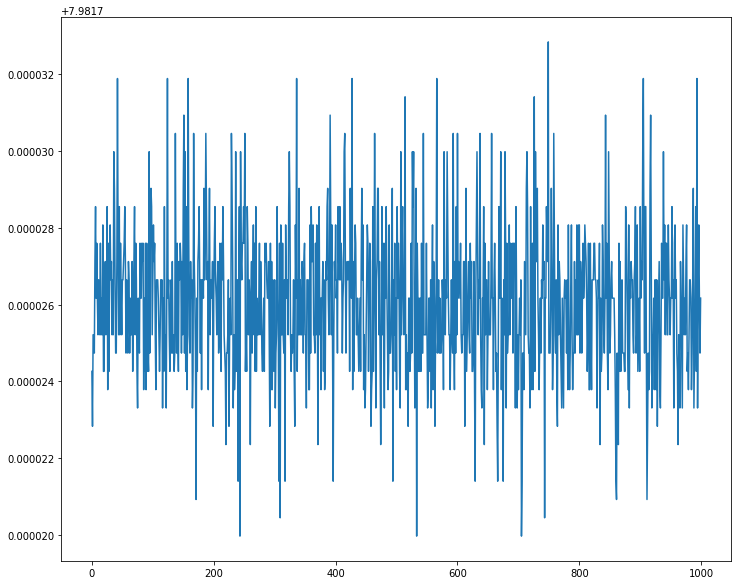

In [306]:
fig, ax = plt.subplots(figsize = (12,10))
ax.plot(train_loss_list)


### Here begins the evaluation part

In [292]:
import os
checkpoint_dir = os.getcwd()

In [ ]:

#Reference: lab8 3_mri
def save_checkpoint(encoder, decoder, checkpoint_dir):
    enc_filename = "{}/enc-{}.pth".format(checkpoint_dir, time.strftime("%d%m%y-%H%M%S"))
    dec_filename = "{}/dec-{}.pth".format(checkpoint_dir, time.strftime("%d%m%y-%H%M%S"))
    torch.save(encoder.state_dict(), enc_filename)
    torch.save(decoder.state_dict(), dec_filename)
    print("Model saved.")

def train(train_dataset, batch_size, n_epochs, batch_encoder, batch_decoder, 
          encoder_optimizer, decoder_optimizer, criterion, 
          clip, checkpoint_dir=None, save_every=500):
    
    train_loader = DataLoader(dataset = train_dataset, 
                              batch_size = batch_size,
                              collate_fn = vocab_collate_func,
                              shuffle = True)
    for i in range(n_epochs):
        tick = time.clock()
        print("Epoch {}/{}".format(i+1, n_epochs))
        losses = []
        for batch_idx, batch in enumerate(train_loader):
            input_list, input_length, output_list, output_length = batch
            loss = train_step(input_list, input_length, output_list, output_length, 
                                batch_encoder, batch_decoder, encoder_optimizer, 
                              decoder_optimizer, criterion)
            losses.append(loss)          
            
            if batch_idx % 100 == 0:
                print("batch: {}, loss: {}".format(batch_idx, loss))
            if checkpoint_dir:
                if batch_idx % save_every == 0:
                    save_checkpoint(batch_encoder, batch_decoder, checkpoint_dir)
        
        tock = time.clock()
        print("Time: {} Avg loss: {}".format(tock-tick, np.mean(losses)))
    
    if checkpoint_dir:
        save_checkpoint(batch_encoder, batch_decoder, checkpoint_dir)

In [ ]:
def beam_evaluate()

In [458]:
def greedy_search(input_list, input_length, encoder, decoder, lang, max_length=MAX_LENGTH):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
#         input_tensor = tensorFromSentence(input_lang, input_list)
#         input_length = input_tensor.size()[0]
        # encode the source lanugage
        max_input_length = input_length.max().item()
        encoder_outputs = torch.zeros(batch_size, max_length, max_input_length, device=device)

        encoder_outputs, encoder_hidden = encoder(input_list, input_length, None)
        
        decoder_input = torch.tensor([SOS_TOKEN]*batch_size, device=device)  # SOS
        # decode the context vector
        decoder_hidden = encoder_hidden[:decoder.n_layers] # decoder starts from the last encoding sentence
        # output of this function
        decoded_batch = torch.zeros((batch_size, max_length))#batch x sentence length
        decoder_attentions = torch.zeros(max_length, batch_size, max_input_length)#in length, each position has attention
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #decoder_attention: B x L
            decoder_attentions[di] = decoder_attention.squeeze(1)
            topv, topi = decoder_output.data.topk(1)  # get candidates
            topi = topi.view(-1)
            decoded_batch[:, di] = topi#Still indexes

            decoder_input = topi.detach()

        #return decoded_words, decoder_attentions[:di + 1]
        decoded_words = batch_translate(decoded_batch, lang)
        return decoded_words, decoded_batch, decoder_attentions

In [462]:
def sentenceFromTensor(tensor, lang):
    seq_idx = tensor.data.cpu().numpy()#A single sentence 
    seq_word = [lang.index2word[seq_idx[i]] for i in range(len(seq_idx))]
    return seq_word
    

In [463]:
def batch_translate(decoded_batch, lang):
    translated_batch = []#A numpy same size as the tensor
    for i in range(decoded_batch.shape[0]):
        translated_batch.append(sentenceFromTensor(decoded_batch[i], lang))
    return translated_batch

In [ ]:
def test_model_score(val_loader, encoder, decoder, search_method = 'greedy', target_lang='zh', max_length):
    encoder.eval()
    decoder.eval()
    total = 0
    total_loss = 0
    predict_file = 'predict_temp'
    predict_lines = open(predict_file, 'w')
    for i, (input_list, input_length, output_list, output_length) in enumerate(val_loader):
        loss = batch_train(
            input_list, input_length, output_list, output_length,
            encoder, decoder,
            encoder_optimizer, decoder_optimizer, criterion
        )
        if search_method == 'greedy':
            decoded_words, decoded_list, decoder_attention = greedy_search(input_list, input_length
                                                                            encoder, decoder, target_lang,
                                                                            max_length = max_length)
        else:
            decoded_words, decoded_list, decoder_attention = beam_evaluate(input_list)
        
        total_loss += loss
        total += 1
        predict_lines.write(''.join(decoded_words) + '\n')
    predict_lines.close()
        
    if target_lang == 'zh':
        target_file = 'iwslt-zh-en-processed/test.tok.en'
    else:
        target_file = 'iwslt-vi-en-processed/test.tok.en'
    result = subprocess.run('cat {} | sacrebleu {}'.format(predict_file,target_file),shell=True,stdout=subprocess.PIPE)
    score = get_blue_score(str(result))
        
    return (total_loss / total), score

In [464]:
decoded_words, decoded_batch, decoder_attentions = greedy_search(input_list, 
                                                                   input_length, batch_encoder_test, 
                                                                   batch_decoder_test, output_lang, 
                                                                   max_length=10)